<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-Projects/blob/main/Beginner/PyTorch-Text-Classification-RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install torchmetrics datasets

In [9]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [19]:
# Import Libraries
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from datasets import load_dataset

from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

from collections import Counter
import re

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load Dataset
dataset = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
# Tokenization and Vocab Building

## Basic Word-Level Tokenizer
def tokenizer(text):
  text = text.lower()
  tokens = re.findall(r'\b\w+\b', text)
  return tokens

## Build Vocabulary From Training Data
counter = Counter()
for sample in dataset['train']:
  tokens = tokenizer(sample['text'])
  counter.update(tokens)

## Create Vocab Dict With <pad> and <unk> Tokens
vocab = {
    '<pad>': 0,
    '<unk>': 1
}

for i, word in enumerate(counter.keys(), start = 2):
  vocab[word] = i

# Function To Convert Text To List Of Token IDs
def encode(text):
  return [vocab.get(token, vocab['<unk>']) for token in tokenizer(text)]

In [9]:
# Custom Dataset Class
class IMDBDataset(Dataset):
  def __init__(self, dataset, split):
    self.data = dataset[split]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    text = self.data[index]['text']
    label = self.data[index]['label']
    encoded = torch.tensor(encode(text), dtype = torch.long)
    return encoded, label

In [8]:
# Collate Function For DataLoader
def collate_fn(batch):
  texts, labels = zip(*batch)
  lengths = [len(x) for x in texts]
  padded = pad_sequence(texts, batch_first = True, padding_value = 0)
  return padded, torch.tensor(labels), torch.tensor(lengths)

In [12]:
# Create DataLoaders
train_dataset = IMDBDataset(dataset, "train")
test_dataset = IMDBDataset(dataset, "test")

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, collate_fn = collate_fn)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, collate_fn = collate_fn)

In [15]:
# RNN Model Class
class RNNModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim):
    super(RNNModel, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx = 0)
    self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first = True)
    self.fc = nn.Linear(hidden_dim, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, text, lenght):
    embedded = self.embedding(text)
    packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first = True, enforce_sorted = False)
    _, hidden = self.rnn(packed)
    out = self.sigmoid(self.fc(hidden.squeeze(0)))
    return out

In [17]:
# Initialize Model, Loss, Optimizer
VOCAB_SIZE = len(vocab)
EMBED_DIM = 64
HIDDEN_DIM = 128

model = RNNModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [18]:
# Training Loop
EPOCHS = 20
training_loss = []

for epoch in range(EPOCHS):
  model.train()
  epoch_loss = 0.0

  for texts, labels, lengths in train_loader:
    texts, labels, lengths = texts.to(device), labels.to(device), lengths.to(device)

    outputs = model(texts, lengths).squeeze()
    loss = criterion(outputs, labels.float())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    training_loss.append(epoch_loss)

  print(f"Epoch: {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

Epoch: 1/20, Loss: 0.0010
Epoch: 2/20, Loss: 0.0008
Epoch: 3/20, Loss: 0.0003
Epoch: 4/20, Loss: 0.0005
Epoch: 5/20, Loss: 0.0008
Epoch: 6/20, Loss: 0.0002
Epoch: 7/20, Loss: 0.0010
Epoch: 8/20, Loss: 0.0006
Epoch: 9/20, Loss: 0.0005
Epoch: 10/20, Loss: 0.0007
Epoch: 11/20, Loss: 0.0002
Epoch: 12/20, Loss: 0.0006
Epoch: 13/20, Loss: 0.0001
Epoch: 14/20, Loss: 0.0004
Epoch: 15/20, Loss: 0.0003
Epoch: 16/20, Loss: 0.0003
Epoch: 17/20, Loss: 0.0001
Epoch: 18/20, Loss: 0.0007
Epoch: 19/20, Loss: 0.0002
Epoch: 20/20, Loss: 0.0006


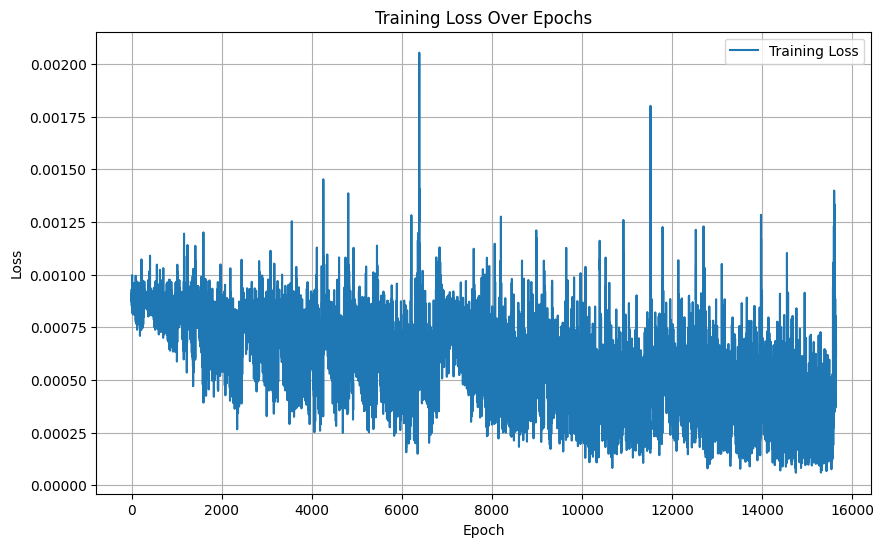

In [20]:
# Plotting The Training Loss
plt.figure(figsize = (10, 6))
plt.plot(training_loss, label = 'Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Evaluation Metrics
accuracy = Accuracy(
    task = "binary",
    num_classes = 2,
    average = 'macro'
).to(device)

precision = Precision(
    task = "binary",
    num_classes = 2,
    average = 'macro'
).to(device)

recall = Recall(
    task = "binary",
    num_classes = 2,
    average = 'macro'
).to(device)

f1score = F1Score(
    task = "binary",
    num_classes = 2,
    average = 'macro'
).to(device)

conf_mat = ConfusionMatrix(
    task = "binary",
    num_classes = 2,
).to(device)